In [2]:
import pandas as pd
pd.set_option('float_format', '{:.5f}'.format)

import numpy as np
np.set_printoptions(formatter={float: lambda x: '{:.5f}'.format(x)})

from sklearn.preprocessing import LabelEncoder

import gc

from datetime import datetime as dt

import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
gc.enable()

In [84]:
def get_additive_decomposition(in_df: pd.DataFrame, plot=True, model='additive'):
    
    if len(in_df.columns.values) > 1:
        print("There is more than one column in DataFrame, using first one.")

    work_col = in_df.columns.values[0]

    model_selector = {
        'additive': 0,
        'multiplicative': 1
    }
    
    if model not in model_selector:
        print("Unknown model.")
        return None

    result = [
        seasonal_decompose(in_df[work_col], model='additive'),
        seasonal_decompose(in_df[work_col], model='multiplicative')
    ]

    if not plot:
        return result[model_selector[model]]
    
    _, ax = plt.subplots(4, 2, figsize=(21, 14))
    axs = ax.flatten()

    y_labels =['Trend', 'Seasonal', 'Observed', 'Residual'] 

    for result_idx in range(2):
        result[result_idx].trend.plot(ax=axs[0 + result_idx])
        result[result_idx].seasonal.plot(ax=axs[2 + result_idx])
        result[result_idx].observed.plot(ax=axs[4 + result_idx])
        result[result_idx].resid.plot(ax=axs[6 + result_idx])

    for axis_idx in range(8)[::2]:
        axs[axis_idx].set_ylabel(y_labels[axis_idx // 2]) 
        axs[axis_idx + 1].set_ylabel(y_labels[axis_idx // 2]) 

    axs[0].set_title("Additive")
    axs[1].set_title("Multiplicative")

    plt.show()

    return result[model_selector[model]]


**Импорт данных**

In [4]:
src_df = pd.read_csv(filepath_or_buffer='./data/train.csv')
src_info_df = pd.DataFrame([src_df.isna().sum(), src_df.dtypes], index=['NaN num', 'Dtype']) 
print(src_info_df.T, "\n")
print(src_df.head(), "\n")
src_df.describe().T

             NaN num    Dtype
Store              0    int64
Dept               0    int64
Date               0   object
Weekly_Sales       0  float64
IsHoliday          0     bool 

   Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  2010-02-05   24924.50000      False
1      1     1  2010-02-12   46039.49000       True
2      1     1  2010-02-19   41595.55000      False
3      1     1  2010-02-26   19403.54000      False
4      1     1  2010-03-05   21827.90000      False 



,count,mean,std,min,25%,50%,75%,max
Store,421570.00000,22.20055,12.78530,1.00000,11.00000,22.00000,33.00000,45.00000
Dept,421570.00000,44.26032,30.49205,1.00000,18.00000,37.00000,74.00000,99.00000
Weekly_Sales,421570.00000,15981.25812,22711.18352,-4988.94000,2079.65000,7612.03000,20205.85250,693099.36000


In [5]:
del src_info_df
gc.collect()

0

In [6]:
src_df['Date'] = pd.to_datetime(src_df['Date'], format='%Y-%m-%d')
src_df.index = src_df['Date'].values
src_df.drop(['Date'], axis=1, inplace=True)
src_df['IsHoliday'] = LabelEncoder().fit_transform(src_df['IsHoliday'])
src_df.sort_index(inplace=True)
src_df.sort_values(['Store', 'Dept'], inplace=True)

In [7]:

src_df.head()

,Store,Dept,Weekly_Sales,IsHoliday
2010-02-05,1,1,24924.50000,0
2010-02-12,1,1,46039.49000,1
2010-02-19,1,1,41595.55000,0
2010-02-26,1,1,19403.54000,0
2010-03-05,1,1,21827.90000,0


In [8]:
src_df.index.min
unique_keys = np.unique(src_df.index, return_counts=True)[0]
print("Dataset have {} unique dates.\nMin - {:%Y-%m-%d}\nMax - {:%Y-%m-%d}".format(len(unique_keys), src_df.index.min(), src_df.index.max()))

Dataset have 143 unique dates.
Min - 2010-02-05
Max - 2012-10-26


In [9]:
src_df.groupby([src_df.index, src_df.Store, src_df.Dept]).aggregate(np.sum)

Weekly_Sales  IsHoliday
           Store Dept                         
2010-02-05 1     1      24924.50000          0
                 2      50605.27000          0
                 3      13740.12000          0
                 4      39954.04000          0
                 5      32229.38000          0
...                             ...        ...
2012-10-26 45    93      2487.80000          0
                 94      5203.31000          0
                 95     56017.47000          0
                 97      6817.48000          0
                 98      1076.80000          0

[421570 rows x 2 columns]

Исследовать все магазины и отделы будет очень долго. Выберу несолько магазинов и отделов. Попробую их проанализировать.

Интервал недельный. Не вижу особой разницы, какой магазин и отдел выбирать, возьму какой-то случайным образом.

In [86]:
S8D5_df = src_df.loc[(src_df['Store'] == 8) & (src_df['Dept'] == 5)].drop(['Store', 'Dept', 'IsHoliday'], axis=1)
print("Period is {}.".format(S8D5_df.index.inferred_freq))
#S8D5_df.index.freq = S8D5_df.index.inferred_freq

Period is W-FRI.


Без применения специальных библиотек мало что можно понять. Пока видно, что в декабре какие-то пики и судя по всему на какие-то праздники.

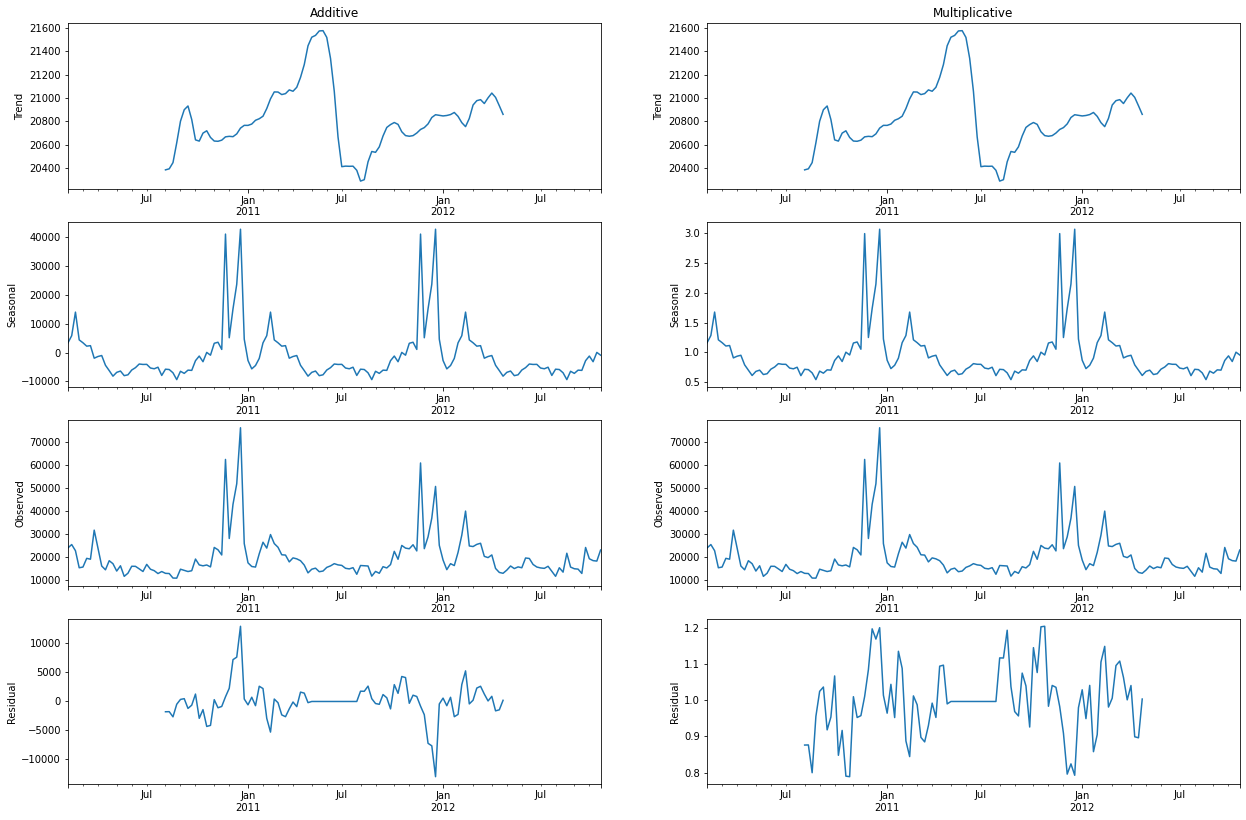

In [87]:
S8D5_additive_decomposition = get_additive_decomposition(in_df=S8D5_df, plot=True, model='additive')